In [12]:
from functools import partial
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

from swimpde.ansatz import BasicAnsatz
from swimpde.domain import Domain
from swimpde.boundary import Dirichlet
from swimpde.equation import Poisson
from swimpde.solver import StaticSolver

Set parameters of the equation

In [13]:
def u_true(xyz):
    return np.sin(xyz[:, 0] ** 2 * np.pi) * np.sin(xyz[:, 1] ** 2 * np.pi)

def forcing(xyz):
    pi_x = np.pi * xyz[:, 0] ** 2
    pi_y = np.pi * xyz[:, 1] ** 2
    return (
        2 * np.pi *
        (
            np.cos(pi_y) * np.sin(pi_x)
            + (np.cos(pi_x) - 2 *(pi_x + pi_y) * np.sin(pi_x))
            * np.sin(pi_y)
        )
    ).reshape((-1, 1))

def boundary(xyz):
    return u_true(xyz).reshape((-1, 1))

x_span = 0, 1.4
n_dim = 2
noise_level = 0

Create data for training and evaluation

In [14]:
# Evaluation data to test the results on.
n_test_sqrt = 101

x_test = np.linspace(*x_span, num=n_test_sqrt)
y_test = np.linspace(*x_span, num=n_test_sqrt)
xy_test = np.stack(np.meshgrid(x_test, y_test), axis=-1).reshape(-1, n_dim)
u_test = u_true(xy_test)

In [15]:
# Measurement points to use for training.
n_measurement_points = 50

rng = np.random.default_rng(10)
measurement_points = rng.uniform(*x_span, size=(n_measurement_points, n_dim))
noise = rng.normal(size=n_measurement_points) * noise_level
u_measured = u_true(measurement_points) + noise
u_measured = u_measured.reshape(-1, 1)

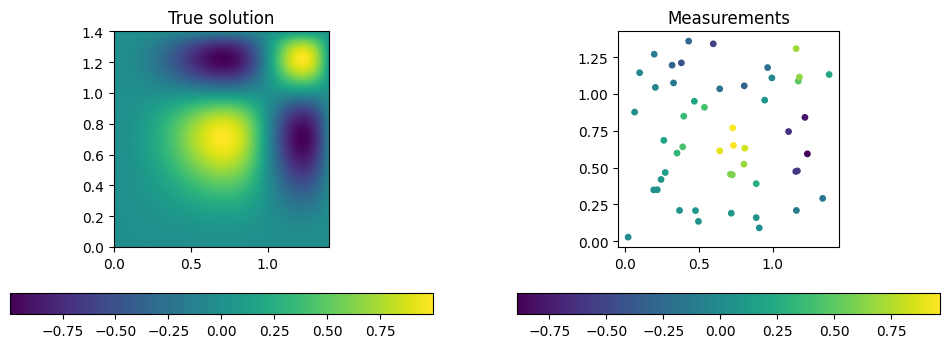

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the test data.
u_test_square = u_test.reshape(n_test_sqrt, n_test_sqrt)
im = axes[0].imshow(u_test_square, extent=[*x_span, *x_span], origin="lower")
axes[0].set_title("True solution")
fig.colorbar(im, ax=axes[0], orientation="horizontal")

# Plot the measurements.
sc = axes[1].scatter(*measurement_points.T, c=u_measured, s=15)
axes[1].set_title("Measurements");
axes[1].set_aspect("equal")
fig.colorbar(sc, ax=axes[1], orientation="horizontal");


In [17]:
# Domain data
n_domain_points = 900
rng = np.random.default_rng(42)
interior_points = rng.uniform(*x_span, size=(n_domain_points, n_dim))
domain = Domain(interior_points=interior_points,
                boundary_points=measurement_points)

Define an ansatz and a solver for the Poisson equation

In [18]:
n_basis = 1024

ansatz =  BasicAnsatz(
    activation="tanh",
    parameter_sampler='tanh',
    n_basis=n_basis,
    random_seed=123
)

def solve_poisson(alpha, ansatz, domain):
    equation = Poisson(parameter_scaling=np.array([1, alpha]))
    boundary_condition = Dirichlet(boundary)
    poisson_solver = StaticSolver(
        equation=equation,
        domain=domain,
        f=forcing,
        boundary_condition=boundary_condition,
        ansatz=ansatz,
        regularization_scale=1e-12
    )
    poisson_solver.fit()
    return poisson_solver

Define a loss for the unknown parameter

In [19]:
def alpha_loss(alpha, ansatz, domain, measurement_points):
    solver = solve_poisson(alpha, ansatz, domain)
    pred = solver.evaluate(measurement_points)
    true = u_measured
    return np.linalg.norm(pred - true)

Find the optimal alpha

In [20]:
alpha_bounds = (0, 2.0)

loss_fn = partial(alpha_loss,
                  ansatz=ansatz,
                  domain=domain,
                  measurement_points=measurement_points)

start_training = time()
sol = minimize_scalar(loss_fn, bounds=alpha_bounds)
training_time = time() - start_training

print(f"Training time: {training_time:3f}")
print(f"Estimated alpha: {sol.x:.6f}")

Training time: 4.400149
Estimated alpha: 1.000001


Evaluate the solution

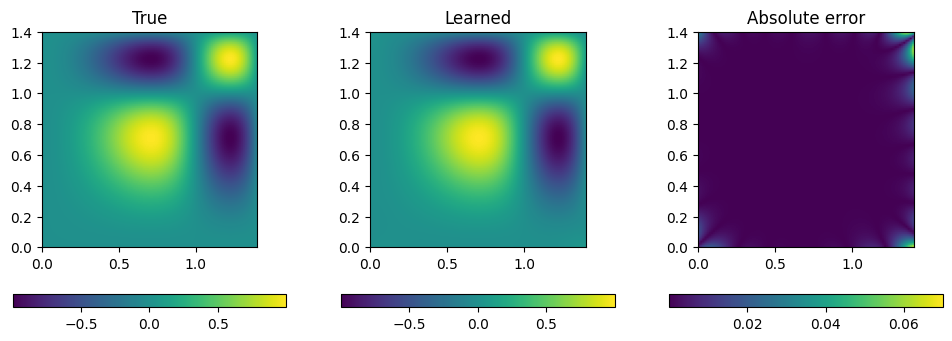

In [21]:
solver = solve_poisson(sol.x, ansatz, domain)
u_pred = solver.evaluate(xy_test).squeeze()
abs_error = np.abs(u_test - u_pred)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

data = {"True": u_test,
        "Learned": u_pred,
        "Absolute error": abs_error}
for ax, label in zip(axes, data):
    squared = data[label].reshape(n_test_sqrt, n_test_sqrt)
    im = ax.imshow(squared, extent=[*x_span, *x_span], origin="lower")
    ax.set_title(label)
    fig.colorbar(im, ax=ax, orientation="horizontal")

We can also plot the loss curve for alpha

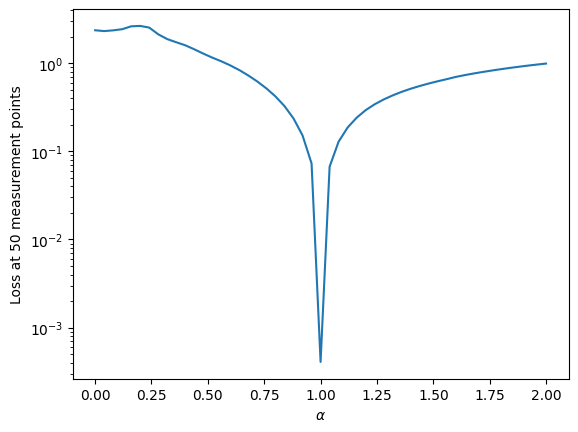

In [22]:
n_alphas = 51
alphas = np.linspace(*alpha_bounds, n_alphas)
losses = [loss_fn(alpha) for alpha in alphas]

fig, ax = plt.subplots()
ax.semilogy(alphas, losses)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(rf"Loss at {n_measurement_points} measurement points");